In [82]:
using LinearAlgebra
using Random
using FFTW
using Plots
using LaTeXStrings

Random.seed!(72)

TaskLocalRNG()

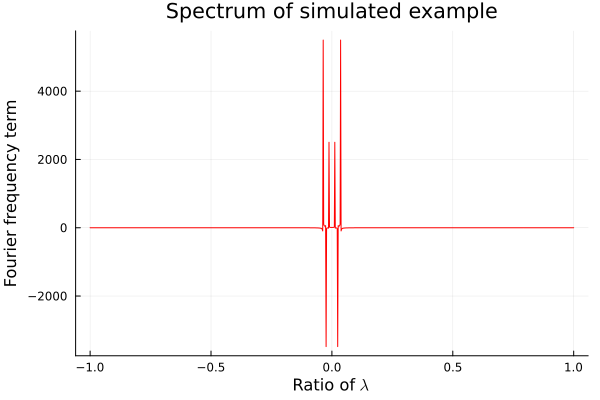

In [83]:
percent  = 0.05
n        = 1000
n₂       = round(Int, n/2)
n₄       = round(Int, n/4)
m        = round(Int, n*percent)

f(x:: Number) =5*cos(2*π*x)-7*cos(4*π*x)+11*cos(6*π*x)

# Set spectrum fractions
hz_range = range(-1, 1, n+1) 
# n depends on the resolution of the wave spectrum

# -3 to 3 chosen for better plots because normal distribution rarely exceeds
t_smooth              = range(-3, 3, n)
interferogram_smooth  = f.(t_smooth)

# Spectrum from linear system
smooth_spectrum = rfft(interferogram_smooth)
smooth_spectrum = vcat(reverse(conj.(smooth_spectrum[2:end])), smooth_spectrum)

plot(hz_range, real.(smooth_spectrum), color=:red, label="")
plot!(title="Spectrum of simulated example", xlabel="Ratio of "*L"\lambda", ylabel="Fourier frequency term")

4×4 Matrix{Float64}:
 1000.0             6.39488e-13     1.10845e-12     1.84741e-13
    6.39488e-13  1000.0            -5.25802e-13     1.06581e-12
    1.10845e-12    -5.25802e-13  1000.0            -1.13687e-13
    1.84741e-13     1.06581e-12    -1.13687e-13  1000.0

4×4 Matrix{Float64}:
 1.0          3.90937e-14  2.10526e-14  1.47937e-14
 3.90937e-14  1.7597e-14   1.26635e-14  1.16886e-14
 2.10387e-14  1.26565e-14  1.04292e-14  8.11851e-15
 1.48076e-14  1.16851e-14  8.10463e-15  1.23027e-14

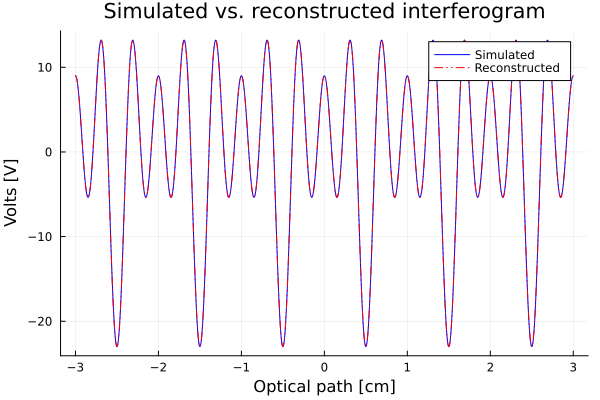

In [84]:
DFT_smooth = [exp(-2*π*im*m*k/n) for m=0:n-1, k=-n₂:n₂]
iDFT_smooth = [exp(2*π*im*m*k/n)/n for m=0:n-1, k=-n₂:n₂]

display(real(DFT_smooth'DFT_smooth)[begin:4, begin:4])
display(real(DFT_smooth'iDFT_smooth)[begin:4, begin:4])

# Get interferogram to check
interferogram_from_smooth = iDFT_smooth*smooth_spectrum

plot(t_smooth, interferogram_smooth, color=:blue, label="Simulated")
plot!(t_smooth, real(interferogram_from_smooth), color=:red, label="Reconstructed", linestyle=:dashdotdot)
plot!(title="Simulated vs. reconstructed interferogram", xlabel="Optical path [cm]", ylabel="Volts [V]")

4×4 Matrix{Float64}:
 1000.0     999.979   999.918   999.815
  999.979  1000.0     999.979   999.918
  999.918   999.979  1000.0     999.979
  999.815   999.918   999.979  1000.0

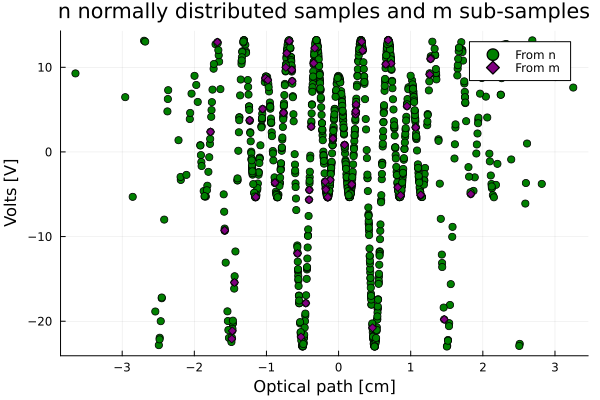

In [85]:
function DFTx(x:: Vector{<:Number}; n=n, n₂=n₂)
    ω₁=[exp(-2*π*im*x[m]/n) for m=1:n]

    return reduce(hcat, [ω₁.^k for k=-n₂:n₂])
end

function iDFTx(x:: Vector{<:Number}; n=n, n₂=n₂)
    ω₁=[exp(2*π*im*x[m]/n)/n for m=1:n]

    return reduce(hcat, [ω₁.^k for k=-n₂:n₂])
end

# n random samples normally distributed
t_n             = Random.randn(n)
interferogram_n = f.(t_n) 
DFT_n                  = DFTx(t_n)
iDFT_n                  = iDFTx(t_n)

display(real(DFT_n'DFT_n)[begin:4, begin:4])

# Choose m random samples from the previous n
rows_id                = randsubseq(1:n, percent)
t_sample_m             = t_n[rows_id]
interferogram_sample_m = interferogram_n[rows_id]
DFT_m                  = DFT_n[rows_id, :]
iDFT_m                  = iDFT_n[rows_id, :]

scatter(t_n, interferogram_n, color=:green, label="From n")
scatter!(t_sample_m, interferogram_sample_m, color=:purple, markershape=:diamond, label="From m")
plot!(title="n normally distributed samples and m sub-samples", xlabel="Optical path [cm]", ylabel="Volts [V]")

In [87]:
spectrum_n=iDFT_n\interferogram_n

print(norm(real.(spectrum_n), Inf), size(iDFT_n))

plot(hz_range, real.(smooth_spectrum), color=:red, label="Direct DFP of n regular points")
plot!(hz_range, real.(spectrum_n), color=:green, label="Inverse from n normally distributed points")
plot!(title="Direct DFP vs. inverse problem", xlabel="Ratio of "*L"\lambda", ylabel="Fourier frequency term")

ArgumentError: ArgumentError: invalid argument #4 to LAPACK call